In [1]:
from __future__ import print_function
import os
from os import path

import sys
import numpy as np
np.random.seed(1337)

import pandas as pd

### Importing texts

In [2]:
# check if file exists
print ("File exists:"+str(path.exists("ABSACOMBINED.csv")))

# import text and remove those with null category
input_data = pd.read_csv("ABSACOMBINED.csv")
print('Before removing NaN value: ', input_data.shape)
input_data = input_data.dropna(subset=['category'])
print('After removing NaN value: ', input_data.shape)
print(input_data.head(5))

# define data grouped by review id (as dataframe)
grouped_df = input_data.groupby('review_id')
actual_category = grouped_df['category'].agg(lambda column: ",".join(column))
actual_category = actual_category.reset_index(name='category')

# define x_train and y_train data
review_id = input_data.review_id
phrase = input_data.phrase
category = input_data.category
print(category.value_counts())

File exists:True
Before removing NaN value:  (5055, 5)
After removing NaN value:  (5055, 5)
   review_id                                             phrase  \
0          0     judging previous posts used good place longer    
1          1    four arrived noon place empty staff acted like    
2          1  four arrived noon place empty staff acted like...   
3          1              empty staff acted like imposing rude    
4          2        repeated requests sugar threw dishes table    

             category aspect_term  polarity  
0  RESTAURANT#GENERAL       posts  negative  
1     SERVICE#GENERAL       staff  negative  
2     SERVICE#GENERAL        rude  negative  
3     SERVICE#GENERAL        rude  negative  
4     SERVICE#GENERAL         eat  negative  
FOOD#QUALITY                1709
SERVICE#GENERAL              902
AMBIENCE#GENERAL             581
RESTAURANT#GENERAL           535
FOOD#STYLE_OPTIONS           379
DRINKS#QUALITY               191
FOOD#PRICES                  17

In [3]:
MAX_SEQ_LENGTH = 10  # most of the phrase is within length of 10
MAX_NB_WORDS = 400000  # I set this based on the number of words found in the glove.txt
EMBEDDING_DIM = 100  # I tried using glove 100d

#### vectorize the text samples into a 2D integer tensor and padding the sentences

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)
tokenizer.fit_on_texts(phrase)
sequences = tokenizer.texts_to_sequences(phrase)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print ("Let's have a quick look at the word_index data..")
print (list(word_index.items())[:10])

C:\Users\Asus\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 2890 unique tokens.
Let's have a quick look at the word_index data..
[('food', 1), ('great', 2), ('good', 3), ('service', 4), ('place', 5), ('best', 6), ('nice', 7), ('like', 8), ('restaurant', 9), ('excellent', 10)]


In [5]:
tokenised_sequence = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
print(tokenised_sequence)
print('Shape of tokenised output:', tokenised_sequence.shape)

[[2232 1489 2233 ...    0    0    0]
 [ 416  876 1780 ...    8    0    0]
 [ 416  876 1780 ...    8 1781  111]
 ...
 [   3    1   57 ...    0    0    0]
 [   3    1   57 ...    0    0    0]
 [   3    1   57 ...    0    0    0]]
Shape of tokenised output: (5055, 10)


#### Filtering input data based on classes

In [6]:
review_id_list = review_id.tolist()
category_list = category.tolist()

In [7]:
from collections import Counter
from sklearn.utils import class_weight

class_list = ['FOOD#QUALITY', 'SERVICE#GENERAL', 'AMBIENCE#GENERAL', 'RESTAURANT#GENERAL']
filtered_phrase = []
filtered_category = []
filtered_id = []

for i in range(0, len(category_list)):  # to choose the top 4 largest class
    if category_list[i] in class_list:
        filtered_id.append(review_id_list[i])
        filtered_phrase.append(tokenised_sequence[i])
        filtered_category.append(category_list[i])
        
np_phrase = np.array(filtered_phrase)  # So this is without oversampling, the accuracy improves from 0.2 to 0.4 but still all same prob
np_category = np.array(filtered_category)
print(sorted(Counter(np_category).items()))

# class weight to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np_category),
                                                 np_category)
print(class_weights)

[('AMBIENCE#GENERAL', 581), ('FOOD#QUALITY', 1709), ('RESTAURANT#GENERAL', 535), ('SERVICE#GENERAL', 902)]
[1.60370052 0.54520187 1.74158879 1.03298226]


**transform output data into categorical index**

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(np_category)
    
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
print(onehot_encoded.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
(3727, 4)


**Tidy up all variables**

In [9]:
# 80% as training data
# 20% as testing data
import math

phrase_size = np_phrase.shape[0]
category_size = onehot_encoded.shape[0]
assert phrase_size == category_size

train_limit = math.ceil(category_size*0.8)
test_limit = category_size

x_train = np_phrase[:train_limit]
x_test = np_phrase[train_limit:test_limit]
y_train = onehot_encoded[:train_limit]
y_test = onehot_encoded[train_limit:test_limit]
id_test = filtered_id[train_limit:test_limit]

print("Train with " + str(train_limit))
print("Test with " + str(test_limit - train_limit))

Train with 2982
Test with 745


#### Indexing Word Vectors

In [10]:
print('Indexing word vectors.')

embeddings_index = {}

# check if file exists
print ("File exists:"+str(path.exists("glove.6B.100d.txt")))

f = open("glove.6B.100d.txt", 'rb')
for line in f:
    values = line.split()
    word = values[0]
    word = word.decode("utf-8")
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
File exists:True
Found 400000 word vectors.


#### Preparing Embedding Layer

In [11]:
from keras.layers import Embedding

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = len(word_index)
embedding_matrix = np.zeros((nb_words + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(nb_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LENGTH,
                            trainable=False)

Preparing embedding matrix.


### Defining and Training Model

In [12]:
from keras.models import Sequential, Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.preprocessing import sequence
from keras.optimizers import *
from keras.regularizers import l2
from keras.layers import Dense, Input, Flatten
from keras.layers import Dense, LSTM, SpatialDropout1D
from keras.layers import BatchNormalization
import keras

In [13]:
# define our lstm model for Talos parameter sweeping use

def lstm_model(x_train, y_train, x_test, y_test, params):
    
    lstm_out = params['hidden_units']

    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(params['dropout']))
    model.add(LSTM(lstm_out, dropout= params['dropout'], recurrent_dropout=params['dropout']))
    model.add(BatchNormalization())
    model.add(Dense(8,activation='softmax'))
    model.add(Dense(4,activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])
    
    history = model.fit(x_train, y_train,  # 80% as training data
          validation_split=0.1,
          batch_size=params['batch_size'],
          epochs=50, class_weight = class_weights)
    
    return history, model

In [14]:
# different possible values for hyperparameters

p = {'hidden_units':[10, 100, 300],
     'batch_size': [32, 64],
     'dropout': (0, 0.40, 10)}

In [15]:
import talos as ta

# run the experiment
t = ta.Scan(x=x_train,
            y=y_train,
            model=lstm_model,
            params=p,
            experiment_name='aspect_prediction_1')

  0%|          | 0/60 [00:00<?, ?it/s]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 864us/step - loss: 1.3991 - accuracy: 0.2556 - val_loss: 1.3875 - val_accuracy: 0.2105
Epoch 2/50
1878/1878 [==============================] - 1s 312us/step - loss: 1.2930 - accuracy: 0.4398 - val_loss: 1.3110 - val_accuracy: 0.4498
Epoch 3/50
1878/1878 [==============================] - 1s 310us/step - loss: 1.2165 - accuracy: 0.5059 - val_loss: 1.2325 - val_accuracy: 0.4833
Epoch 4/50
1878/1878 [==============================] - 1s 314us/step - loss: 1.1567 - accuracy: 0.5724 - val_loss: 1.1760 - val_accuracy: 0.5550
Epoch 5/50
1878/1878 [==============================] - 1s 336us/step - loss: 1.1062 - accuracy: 0.6102 - val_loss: 1.1303 - val_accuracy: 0.5789
Epoch 6/50
1878/1878 [==============================] - 1s 291us/step - loss: 1.0631 - accuracy: 0.6214 - val_loss: 1.1043 - val_accuracy: 0.5885
Epoch 7/50
1878/1878 [==============================] - 1s 284us/step - loss:

  2%|▏         | 1/60 [00:33<32:51, 33.42s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 967us/step - loss: 1.1966 - accuracy: 0.5415 - val_loss: 1.2641 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 2s 859us/step - loss: 1.0901 - accuracy: 0.6491 - val_loss: 1.1967 - val_accuracy: 0.4354
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0454 - accuracy: 0.6576 - val_loss: 1.1527 - val_accuracy: 0.5167
Epoch 4/50
1878/1878 [==============================] - 2s 896us/step - loss: 1.0053 - accuracy: 0.6816 - val_loss: 1.0866 - val_accuracy: 0.6077
Epoch 5/50
1878/1878 [==============================] - 1s 646us/step - loss: 0.9575 - accuracy: 0.7039 - val_loss: 1.0456 - val_accuracy: 0.6077
Epoch 6/50
1878/1878 [==============================] - 1s 605us/step - loss: 0.9225 - accuracy: 0.7114 - val_loss: 1.0168 - val_accuracy: 0.6172
Epoch 7/50
1878/1878 [==============================] - 1s 666us/step - loss: 0

  3%|▎         | 2/60 [01:23<37:03, 38.34s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.2267 - accuracy: 0.5458 - val_loss: 1.2369 - val_accuracy: 0.4976
Epoch 2/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1477 - accuracy: 0.6124 - val_loss: 1.1875 - val_accuracy: 0.5598
Epoch 3/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1008 - accuracy: 0.6140 - val_loss: 1.1434 - val_accuracy: 0.5789
Epoch 4/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.0541 - accuracy: 0.6363 - val_loss: 1.1071 - val_accuracy: 0.5837
Epoch 5/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0314 - accuracy: 0.6353 - val_loss: 1.0762 - val_accuracy: 0.6316
Epoch 6/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0074 - accuracy: 0.6374 - val_loss: 1.0941 - val_accuracy: 0.5455
Epoch 7/50
1878/1878 [==============================] - 3s 2ms/step - loss: 0.9895 - accu

  5%|▌         | 3/60 [03:31<1:01:58, 65.24s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 987us/step - loss: 1.3597 - accuracy: 0.3269 - val_loss: 1.3395 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 318us/step - loss: 1.2734 - accuracy: 0.4744 - val_loss: 1.3031 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 1s 298us/step - loss: 1.1992 - accuracy: 0.5224 - val_loss: 1.2534 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 266us/step - loss: 1.1353 - accuracy: 0.5703 - val_loss: 1.1982 - val_accuracy: 0.4354
Epoch 5/50
1878/1878 [==============================] - 0s 252us/step - loss: 1.0783 - accuracy: 0.6092 - val_loss: 1.1255 - val_accuracy: 0.5359
Epoch 6/50
1878/1878 [==============================] - 0s 256us/step - loss: 1.0310 - accuracy: 0.6305 - val_loss: 1.0768 - val_accuracy: 0.5933
Epoch 7/50
1878/1878 [==============================] - 1s 345us/step - loss:

  7%|▋         | 4/60 [04:00<50:56, 54.57s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 957us/step - loss: 1.3336 - accuracy: 0.4105 - val_loss: 1.3520 - val_accuracy: 0.3349
Epoch 2/50
1878/1878 [==============================] - 1s 514us/step - loss: 1.2237 - accuracy: 0.6246 - val_loss: 1.2675 - val_accuracy: 0.5502
Epoch 3/50
1878/1878 [==============================] - 1s 461us/step - loss: 1.1577 - accuracy: 0.6395 - val_loss: 1.2170 - val_accuracy: 0.5742
Epoch 4/50
1878/1878 [==============================] - 1s 504us/step - loss: 1.1097 - accuracy: 0.6587 - val_loss: 1.1676 - val_accuracy: 0.6029
Epoch 5/50
1878/1878 [==============================] - 1s 461us/step - loss: 1.0713 - accuracy: 0.6757 - val_loss: 1.1047 - val_accuracy: 0.6411
Epoch 6/50
1878/1878 [==============================] - 1s 437us/step - loss: 1.0301 - accuracy: 0.6906 - val_loss: 1.0873 - val_accuracy: 0.6507
Epoch 7/50
1878/1878 [==============================] - 1s 456us/step - loss:

  8%|▊         | 5/60 [04:48<48:06, 52.48s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2264 - accuracy: 0.5202 - val_loss: 1.3008 - val_accuracy: 0.4067
Epoch 2/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1437 - accuracy: 0.5708 - val_loss: 1.1976 - val_accuracy: 0.5646
Epoch 3/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1114 - accuracy: 0.5836 - val_loss: 1.1876 - val_accuracy: 0.5263
Epoch 4/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0804 - accuracy: 0.5942 - val_loss: 1.1194 - val_accuracy: 0.5742
Epoch 5/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0439 - accuracy: 0.6124 - val_loss: 1.1050 - val_accuracy: 0.5694
Epoch 6/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0383 - accuracy: 0.6108 - val_loss: 1.1106 - val_accuracy: 0.5885
Epoch 7/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0087 - accu

 10%|█         | 6/60 [07:12<1:12:01, 80.02s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 827us/step - loss: 1.3824 - accuracy: 0.2497 - val_loss: 1.3618 - val_accuracy: 0.2775
Epoch 2/50
1878/1878 [==============================] - 1s 317us/step - loss: 1.3147 - accuracy: 0.3387 - val_loss: 1.3306 - val_accuracy: 0.4067
Epoch 3/50
1878/1878 [==============================] - 1s 315us/step - loss: 1.2582 - accuracy: 0.4824 - val_loss: 1.2951 - val_accuracy: 0.4067
Epoch 4/50
1878/1878 [==============================] - 1s 313us/step - loss: 1.1999 - accuracy: 0.5357 - val_loss: 1.2532 - val_accuracy: 0.4306
Epoch 5/50
1878/1878 [==============================] - 1s 316us/step - loss: 1.1524 - accuracy: 0.5437 - val_loss: 1.2065 - val_accuracy: 0.4641
Epoch 6/50
1878/1878 [==============================] - 1s 312us/step - loss: 1.1128 - accuracy: 0.5703 - val_loss: 1.1646 - val_accuracy: 0.5311
Epoch 7/50
1878/1878 [==============================] - 1s 314us/step - loss:

 12%|█▏        | 7/60 [07:41<57:12, 64.76s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2506 - accuracy: 0.4808 - val_loss: 1.2833 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 483us/step - loss: 1.1637 - accuracy: 0.5655 - val_loss: 1.2237 - val_accuracy: 0.4880
Epoch 3/50
1878/1878 [==============================] - 1s 491us/step - loss: 1.1174 - accuracy: 0.6012 - val_loss: 1.1694 - val_accuracy: 0.5359
Epoch 4/50
1878/1878 [==============================] - 1s 439us/step - loss: 1.0830 - accuracy: 0.5985 - val_loss: 1.1332 - val_accuracy: 0.5120
Epoch 5/50
1878/1878 [==============================] - 1s 417us/step - loss: 1.0458 - accuracy: 0.6230 - val_loss: 1.0935 - val_accuracy: 0.5885
Epoch 6/50
1878/1878 [==============================] - 1s 397us/step - loss: 1.0168 - accuracy: 0.6656 - val_loss: 1.0689 - val_accuracy: 0.5981
Epoch 7/50
1878/1878 [==============================] - 1s 424us/step - loss: 1

 13%|█▎        | 8/60 [08:28<51:23, 59.30s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.2666 - accuracy: 0.5096 - val_loss: 1.2651 - val_accuracy: 0.5120
Epoch 2/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1965 - accuracy: 0.5389 - val_loss: 1.2239 - val_accuracy: 0.5215
Epoch 3/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1522 - accuracy: 0.5655 - val_loss: 1.2183 - val_accuracy: 0.4737
Epoch 4/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1245 - accuracy: 0.5809 - val_loss: 1.1542 - val_accuracy: 0.5742
Epoch 5/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.0958 - accuracy: 0.5990 - val_loss: 1.1504 - val_accuracy: 0.5502
Epoch 6/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0671 - accuracy: 0.6305 - val_loss: 1.0919 - val_accuracy: 0.6268
Epoch 7/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0382 - accu

 15%|█▌        | 9/60 [11:07<1:15:51, 89.25s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.3294 - accuracy: 0.3866 - val_loss: 1.3287 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 332us/step - loss: 1.2720 - accuracy: 0.4782 - val_loss: 1.2985 - val_accuracy: 0.4019
Epoch 3/50
1878/1878 [==============================] - 1s 460us/step - loss: 1.2227 - accuracy: 0.5032 - val_loss: 1.2617 - val_accuracy: 0.4163
Epoch 4/50
1878/1878 [==============================] - 1s 459us/step - loss: 1.1860 - accuracy: 0.5197 - val_loss: 1.2239 - val_accuracy: 0.4641
Epoch 5/50
1878/1878 [==============================] - 0s 242us/step - loss: 1.1487 - accuracy: 0.5575 - val_loss: 1.1815 - val_accuracy: 0.5024
Epoch 6/50
1878/1878 [==============================] - 1s 404us/step - loss: 1.1139 - accuracy: 0.5836 - val_loss: 1.1621 - val_accuracy: 0.5263
Epoch 7/50
1878/1878 [==============================] - 1s 578us/step - loss: 1

 17%|█▋        | 10/60 [11:43<1:00:56, 73.13s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 902us/step - loss: 1.2863 - accuracy: 0.4542 - val_loss: 1.3052 - val_accuracy: 0.4067
Epoch 2/50
1878/1878 [==============================] - 1s 457us/step - loss: 1.1694 - accuracy: 0.5719 - val_loss: 1.2208 - val_accuracy: 0.5598
Epoch 3/50
1878/1878 [==============================] - 1s 440us/step - loss: 1.1120 - accuracy: 0.5990 - val_loss: 1.1499 - val_accuracy: 0.5550
Epoch 4/50
1878/1878 [==============================] - 1s 433us/step - loss: 1.0792 - accuracy: 0.6070 - val_loss: 1.1025 - val_accuracy: 0.5981
Epoch 5/50
1878/1878 [==============================] - 1s 462us/step - loss: 1.0521 - accuracy: 0.6145 - val_loss: 1.1110 - val_accuracy: 0.5455
Epoch 6/50
1878/1878 [==============================] - 1s 504us/step - loss: 1.0436 - accuracy: 0.6017 - val_loss: 1.0644 - val_accuracy: 0.5981
Epoch 7/50
1878/1878 [==============================] - 1s 436us/step - loss:

 18%|█▊        | 11/60 [12:27<52:39, 64.47s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2553 - accuracy: 0.5021 - val_loss: 1.2545 - val_accuracy: 0.5407
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1823 - accuracy: 0.5586 - val_loss: 1.1936 - val_accuracy: 0.5120
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1532 - accuracy: 0.5751 - val_loss: 1.1686 - val_accuracy: 0.5359
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1148 - accuracy: 0.5841 - val_loss: 1.1544 - val_accuracy: 0.5263
Epoch 5/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1008 - accuracy: 0.5804 - val_loss: 1.0704 - val_accuracy: 0.5885
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0632 - accuracy: 0.6140 - val_loss: 1.0785 - val_accuracy: 0.5694
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0570 - accu

 20%|██        | 12/60 [14:20<1:03:09, 78.95s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 757us/step - loss: 1.3850 - accuracy: 0.2721 - val_loss: 1.3625 - val_accuracy: 0.3876
Epoch 2/50
1878/1878 [==============================] - 1s 325us/step - loss: 1.2998 - accuracy: 0.4654 - val_loss: 1.3166 - val_accuracy: 0.4115
Epoch 3/50
1878/1878 [==============================] - 1s 298us/step - loss: 1.2260 - accuracy: 0.5101 - val_loss: 1.2581 - val_accuracy: 0.4641
Epoch 4/50
1878/1878 [==============================] - 1s 272us/step - loss: 1.1721 - accuracy: 0.5245 - val_loss: 1.2043 - val_accuracy: 0.5120
Epoch 5/50
1878/1878 [==============================] - 0s 258us/step - loss: 1.1318 - accuracy: 0.5426 - val_loss: 1.1680 - val_accuracy: 0.5167
Epoch 6/50
1878/1878 [==============================] - 0s 259us/step - loss: 1.1058 - accuracy: 0.5580 - val_loss: 1.1330 - val_accuracy: 0.5407
Epoch 7/50
1878/1878 [==============================] - 0s 259us/step - loss:

 22%|██▏       | 13/60 [14:47<49:48, 63.59s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 8s 4ms/step - loss: 1.2598 - accuracy: 0.4920 - val_loss: 1.2798 - val_accuracy: 0.4833
Epoch 2/50
1878/1878 [==============================] - 1s 607us/step - loss: 1.1574 - accuracy: 0.5682 - val_loss: 1.2048 - val_accuracy: 0.5311
Epoch 3/50
1878/1878 [==============================] - 1s 625us/step - loss: 1.1092 - accuracy: 0.5889 - val_loss: 1.1538 - val_accuracy: 0.5646
Epoch 4/50
1878/1878 [==============================] - 1s 656us/step - loss: 1.0779 - accuracy: 0.5900 - val_loss: 1.1036 - val_accuracy: 0.5837
Epoch 5/50
1878/1878 [==============================] - 1s 650us/step - loss: 1.0479 - accuracy: 0.6044 - val_loss: 1.0540 - val_accuracy: 0.5885
Epoch 6/50
1878/1878 [==============================] - 1s 640us/step - loss: 1.0430 - accuracy: 0.5873 - val_loss: 1.0579 - val_accuracy: 0.5694
Epoch 7/50
1878/1878 [==============================] - 1s 756us/step - loss: 1

 23%|██▎       | 14/60 [16:06<52:07, 67.98s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2971 - accuracy: 0.3908 - val_loss: 1.2962 - val_accuracy: 0.5694
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2224 - accuracy: 0.5607 - val_loss: 1.2277 - val_accuracy: 0.5550
Epoch 3/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1862 - accuracy: 0.5820 - val_loss: 1.1838 - val_accuracy: 0.5885
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1405 - accuracy: 0.6012 - val_loss: 1.2478 - val_accuracy: 0.4402
Epoch 5/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1143 - accuracy: 0.6150 - val_loss: 1.1250 - val_accuracy: 0.6124
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0959 - accuracy: 0.6278 - val_loss: 1.1055 - val_accuracy: 0.6077
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0726 - accu

 25%|██▌       | 15/60 [18:07<1:02:58, 83.97s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 770us/step - loss: 1.3733 - accuracy: 0.3424 - val_loss: 1.3640 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 352us/step - loss: 1.2872 - accuracy: 0.4446 - val_loss: 1.3109 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 1s 356us/step - loss: 1.2354 - accuracy: 0.4505 - val_loss: 1.2581 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 1s 312us/step - loss: 1.1961 - accuracy: 0.4606 - val_loss: 1.2122 - val_accuracy: 0.4019
Epoch 5/50
1878/1878 [==============================] - 1s 351us/step - loss: 1.1708 - accuracy: 0.4872 - val_loss: 1.1759 - val_accuracy: 0.4689
Epoch 6/50
1878/1878 [==============================] - 1s 399us/step - loss: 1.1419 - accuracy: 0.5261 - val_loss: 1.1590 - val_accuracy: 0.4928
Epoch 7/50
1878/1878 [==============================] - 1s 276us/step - loss:

 27%|██▋       | 16/60 [18:35<49:15, 67.16s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 844us/step - loss: 1.2690 - accuracy: 0.4558 - val_loss: 1.2941 - val_accuracy: 0.4019
Epoch 2/50
1878/1878 [==============================] - 1s 435us/step - loss: 1.1760 - accuracy: 0.5176 - val_loss: 1.2394 - val_accuracy: 0.4880
Epoch 3/50
1878/1878 [==============================] - 1s 407us/step - loss: 1.1375 - accuracy: 0.5389 - val_loss: 1.1807 - val_accuracy: 0.5072
Epoch 4/50
1878/1878 [==============================] - 1s 384us/step - loss: 1.1132 - accuracy: 0.5575 - val_loss: 1.1324 - val_accuracy: 0.5455
Epoch 5/50
1878/1878 [==============================] - 1s 433us/step - loss: 1.0766 - accuracy: 0.5799 - val_loss: 1.1015 - val_accuracy: 0.5981
Epoch 6/50
1878/1878 [==============================] - 1s 405us/step - loss: 1.0644 - accuracy: 0.5969 - val_loss: 1.0876 - val_accuracy: 0.5789
Epoch 7/50
1878/1878 [==============================] - 1s 415us/step - loss:

 28%|██▊       | 17/60 [22:08<1:19:32, 110.98s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.3331 - accuracy: 0.3530 - val_loss: 1.3506 - val_accuracy: 0.4067
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2527 - accuracy: 0.5346 - val_loss: 1.2647 - val_accuracy: 0.5981
Epoch 3/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1882 - accuracy: 0.5969 - val_loss: 1.2046 - val_accuracy: 0.5933
Epoch 4/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.1617 - accuracy: 0.5927 - val_loss: 1.1852 - val_accuracy: 0.5789
Epoch 5/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1141 - accuracy: 0.6241 - val_loss: 1.1183 - val_accuracy: 0.5885
Epoch 6/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1009 - accuracy: 0.6081 - val_loss: 1.1123 - val_accuracy: 0.6077
Epoch 7/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0879 - accu

 30%|███       | 18/60 [24:44<1:27:05, 124.42s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.3637 - accuracy: 0.2812 - val_loss: 1.3407 - val_accuracy: 0.3349
Epoch 2/50
1878/1878 [==============================] - 1s 338us/step - loss: 1.3184 - accuracy: 0.3972 - val_loss: 1.3186 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 1s 381us/step - loss: 1.2734 - accuracy: 0.4558 - val_loss: 1.2950 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 1s 383us/step - loss: 1.2416 - accuracy: 0.4686 - val_loss: 1.2648 - val_accuracy: 0.3971
Epoch 5/50
1878/1878 [==============================] - 1s 360us/step - loss: 1.2064 - accuracy: 0.4968 - val_loss: 1.2246 - val_accuracy: 0.4211
Epoch 6/50
1878/1878 [==============================] - 1s 375us/step - loss: 1.1661 - accuracy: 0.5170 - val_loss: 1.1733 - val_accuracy: 0.4976
Epoch 7/50
1878/1878 [==============================] - 1s 463us/step - loss: 1

 32%|███▏      | 19/60 [25:31<1:09:14, 101.32s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.3095 - accuracy: 0.4185 - val_loss: 1.3357 - val_accuracy: 0.4593
Epoch 2/50
1878/1878 [==============================] - 1s 532us/step - loss: 1.2225 - accuracy: 0.5197 - val_loss: 1.2572 - val_accuracy: 0.5263
Epoch 3/50
1878/1878 [==============================] - 1s 656us/step - loss: 1.1797 - accuracy: 0.5373 - val_loss: 1.1827 - val_accuracy: 0.5598
Epoch 4/50
1878/1878 [==============================] - 1s 442us/step - loss: 1.1483 - accuracy: 0.5431 - val_loss: 1.1438 - val_accuracy: 0.5646
Epoch 5/50
1878/1878 [==============================] - 1s 788us/step - loss: 1.1214 - accuracy: 0.5724 - val_loss: 1.1297 - val_accuracy: 0.5311
Epoch 6/50
1878/1878 [==============================] - 1s 666us/step - loss: 1.0940 - accuracy: 0.5714 - val_loss: 1.1002 - val_accuracy: 0.5407
Epoch 7/50
1878/1878 [==============================] - 1s 664us/step - loss: 1

 33%|███▎      | 20/60 [26:36<1:00:13, 90.35s/it] 

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2427 - accuracy: 0.4973 - val_loss: 1.2579 - val_accuracy: 0.5072
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1795 - accuracy: 0.5447 - val_loss: 1.2138 - val_accuracy: 0.4928
Epoch 3/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1481 - accuracy: 0.5506 - val_loss: 1.1794 - val_accuracy: 0.5120
Epoch 4/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1295 - accuracy: 0.5548 - val_loss: 1.1292 - val_accuracy: 0.5694
Epoch 5/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.0960 - accuracy: 0.5900 - val_loss: 1.1103 - val_accuracy: 0.6077
Epoch 6/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.0945 - accuracy: 0.5868 - val_loss: 1.1040 - val_accuracy: 0.5502
Epoch 7/50
1878/1878 [==============================] - 4s 2ms/step - loss: 1.0838 - accu

 35%|███▌      | 21/60 [29:45<1:17:59, 119.99s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.3525 - accuracy: 0.3408 - val_loss: 1.3509 - val_accuracy: 0.3254
Epoch 2/50
1878/1878 [==============================] - 1s 349us/step - loss: 1.2699 - accuracy: 0.4579 - val_loss: 1.2785 - val_accuracy: 0.5263
Epoch 3/50
1878/1878 [==============================] - 1s 348us/step - loss: 1.2297 - accuracy: 0.4846 - val_loss: 1.2207 - val_accuracy: 0.5359
Epoch 4/50
1878/1878 [==============================] - 1s 454us/step - loss: 1.2064 - accuracy: 0.4995 - val_loss: 1.1842 - val_accuracy: 0.5263
Epoch 5/50
1878/1878 [==============================] - 1s 548us/step - loss: 1.1806 - accuracy: 0.5122 - val_loss: 1.1603 - val_accuracy: 0.5359
Epoch 6/50
1878/1878 [==============================] - 1s 414us/step - loss: 1.1591 - accuracy: 0.5245 - val_loss: 1.1365 - val_accuracy: 0.5455
Epoch 7/50
1878/1878 [==============================] - 1s 379us/step - loss: 1

 37%|███▋      | 22/60 [30:23<1:00:24, 95.38s/it] 

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 842us/step - loss: 1.3069 - accuracy: 0.4292 - val_loss: 1.3174 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 434us/step - loss: 1.2213 - accuracy: 0.5021 - val_loss: 1.2412 - val_accuracy: 0.4067
Epoch 3/50
1878/1878 [==============================] - 1s 431us/step - loss: 1.1808 - accuracy: 0.5437 - val_loss: 1.2117 - val_accuracy: 0.4498
Epoch 4/50
1878/1878 [==============================] - 1s 427us/step - loss: 1.1420 - accuracy: 0.5543 - val_loss: 1.1584 - val_accuracy: 0.5215
Epoch 5/50
1878/1878 [==============================] - 1s 429us/step - loss: 1.1335 - accuracy: 0.5591 - val_loss: 1.1368 - val_accuracy: 0.5598
Epoch 6/50
1878/1878 [==============================] - 1s 425us/step - loss: 1.1110 - accuracy: 0.5745 - val_loss: 1.1239 - val_accuracy: 0.5407
Epoch 7/50
1878/1878 [==============================] - 1s 397us/step - loss:

 38%|███▊      | 23/60 [31:07<49:13, 79.82s/it]  

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 5s 3ms/step - loss: 1.2403 - accuracy: 0.4835 - val_loss: 1.2287 - val_accuracy: 0.5550
Epoch 2/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1700 - accuracy: 0.5431 - val_loss: 1.1914 - val_accuracy: 0.5502
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1403 - accuracy: 0.5517 - val_loss: 1.1518 - val_accuracy: 0.5694
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1267 - accuracy: 0.5543 - val_loss: 1.1205 - val_accuracy: 0.5598
Epoch 5/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.0960 - accuracy: 0.5804 - val_loss: 1.1286 - val_accuracy: 0.5502
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0847 - accuracy: 0.5916 - val_loss: 1.1101 - val_accuracy: 0.5646
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0645 - accu

 40%|████      | 24/60 [33:38<1:00:47, 101.33s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 771us/step - loss: 1.3459 - accuracy: 0.3520 - val_loss: 1.3343 - val_accuracy: 0.3493
Epoch 2/50
1878/1878 [==============================] - 1s 295us/step - loss: 1.2971 - accuracy: 0.4526 - val_loss: 1.3051 - val_accuracy: 0.4258
Epoch 3/50
1878/1878 [==============================] - 1s 298us/step - loss: 1.2555 - accuracy: 0.4883 - val_loss: 1.2707 - val_accuracy: 0.4354
Epoch 4/50
1878/1878 [==============================] - 0s 258us/step - loss: 1.2207 - accuracy: 0.4984 - val_loss: 1.2314 - val_accuracy: 0.4689
Epoch 5/50
1878/1878 [==============================] - 0s 258us/step - loss: 1.1907 - accuracy: 0.5160 - val_loss: 1.1902 - val_accuracy: 0.5215
Epoch 6/50
1878/1878 [==============================] - 0s 253us/step - loss: 1.1745 - accuracy: 0.5176 - val_loss: 1.1558 - val_accuracy: 0.5263
Epoch 7/50
1878/1878 [==============================] - 0s 247us/step - loss:

 42%|████▏     | 25/60 [34:09<46:46, 80.18s/it]   

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.3025 - accuracy: 0.4302 - val_loss: 1.3163 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 626us/step - loss: 1.2088 - accuracy: 0.5080 - val_loss: 1.2448 - val_accuracy: 0.4163
Epoch 3/50
1878/1878 [==============================] - 1s 532us/step - loss: 1.1624 - accuracy: 0.5234 - val_loss: 1.1973 - val_accuracy: 0.4354
Epoch 4/50
1878/1878 [==============================] - 1s 463us/step - loss: 1.1338 - accuracy: 0.5410 - val_loss: 1.1520 - val_accuracy: 0.4880
Epoch 5/50
1878/1878 [==============================] - 1s 424us/step - loss: 1.1097 - accuracy: 0.5479 - val_loss: 1.0896 - val_accuracy: 0.5598
Epoch 6/50
1878/1878 [==============================] - 1s 533us/step - loss: 1.0948 - accuracy: 0.5554 - val_loss: 1.1002 - val_accuracy: 0.5646
Epoch 7/50
1878/1878 [==============================] - 1s 449us/step - loss: 1

 43%|████▎     | 26/60 [34:56<39:52, 70.36s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2363 - accuracy: 0.4835 - val_loss: 1.2492 - val_accuracy: 0.4928
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1620 - accuracy: 0.5357 - val_loss: 1.1932 - val_accuracy: 0.4928
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1496 - accuracy: 0.5490 - val_loss: 1.1466 - val_accuracy: 0.5311
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1155 - accuracy: 0.5783 - val_loss: 1.1549 - val_accuracy: 0.5598
Epoch 5/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1203 - accuracy: 0.5543 - val_loss: 1.1128 - val_accuracy: 0.5550
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0995 - accuracy: 0.5724 - val_loss: 1.1126 - val_accuracy: 0.5694
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0942 - accu

 45%|████▌     | 27/60 [37:16<50:10, 91.24s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 791us/step - loss: 1.3431 - accuracy: 0.4004 - val_loss: 1.3369 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 342us/step - loss: 1.2931 - accuracy: 0.4420 - val_loss: 1.3093 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 1s 320us/step - loss: 1.2490 - accuracy: 0.4622 - val_loss: 1.2707 - val_accuracy: 0.4067
Epoch 4/50
1878/1878 [==============================] - 1s 317us/step - loss: 1.2183 - accuracy: 0.4755 - val_loss: 1.2346 - val_accuracy: 0.4306
Epoch 5/50
1878/1878 [==============================] - 1s 315us/step - loss: 1.1953 - accuracy: 0.4862 - val_loss: 1.2049 - val_accuracy: 0.4545
Epoch 6/50
1878/1878 [==============================] - 1s 313us/step - loss: 1.1822 - accuracy: 0.4931 - val_loss: 1.1810 - val_accuracy: 0.4880
Epoch 7/50
1878/1878 [==============================] - 1s 304us/step - loss:

 47%|████▋     | 28/60 [37:51<39:34, 74.20s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2972 - accuracy: 0.4233 - val_loss: 1.2970 - val_accuracy: 0.4019
Epoch 2/50
1878/1878 [==============================] - 1s 543us/step - loss: 1.2184 - accuracy: 0.5101 - val_loss: 1.2485 - val_accuracy: 0.4067
Epoch 3/50
1878/1878 [==============================] - 1s 455us/step - loss: 1.1794 - accuracy: 0.5277 - val_loss: 1.1991 - val_accuracy: 0.5502
Epoch 4/50
1878/1878 [==============================] - 1s 793us/step - loss: 1.1483 - accuracy: 0.5410 - val_loss: 1.1752 - val_accuracy: 0.5837
Epoch 5/50
1878/1878 [==============================] - 1s 741us/step - loss: 1.1268 - accuracy: 0.5777 - val_loss: 1.1620 - val_accuracy: 0.5981
Epoch 6/50
1878/1878 [==============================] - 1s 627us/step - loss: 1.1172 - accuracy: 0.5729 - val_loss: 1.1341 - val_accuracy: 0.5885
Epoch 7/50
1878/1878 [==============================] - 1s 763us/step - loss: 1

 48%|████▊     | 29/60 [38:46<35:24, 68.53s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 5s 2ms/step - loss: 1.2493 - accuracy: 0.4840 - val_loss: 1.2502 - val_accuracy: 0.4306
Epoch 2/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1919 - accuracy: 0.5138 - val_loss: 1.2015 - val_accuracy: 0.4880
Epoch 3/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1842 - accuracy: 0.5165 - val_loss: 1.1799 - val_accuracy: 0.4737
Epoch 4/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1559 - accuracy: 0.5101 - val_loss: 1.1288 - val_accuracy: 0.5215
Epoch 5/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1544 - accuracy: 0.5064 - val_loss: 1.1265 - val_accuracy: 0.5120
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1406 - accuracy: 0.5176 - val_loss: 1.1231 - val_accuracy: 0.5120
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1187 - accu

 50%|█████     | 30/60 [41:24<47:36, 95.22s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 818us/step - loss: 1.3349 - accuracy: 0.4132 - val_loss: 1.3679 - val_accuracy: 0.3493
Epoch 2/50
1878/1878 [==============================] - 1s 274us/step - loss: 1.2754 - accuracy: 0.4909 - val_loss: 1.3391 - val_accuracy: 0.4019
Epoch 3/50
1878/1878 [==============================] - 0s 218us/step - loss: 1.2298 - accuracy: 0.5341 - val_loss: 1.3042 - val_accuracy: 0.4067
Epoch 4/50
1878/1878 [==============================] - 0s 172us/step - loss: 1.1904 - accuracy: 0.5639 - val_loss: 1.2682 - val_accuracy: 0.4545
Epoch 5/50
1878/1878 [==============================] - 0s 195us/step - loss: 1.1584 - accuracy: 0.5761 - val_loss: 1.2346 - val_accuracy: 0.5120
Epoch 6/50
1878/1878 [==============================] - 0s 167us/step - loss: 1.1313 - accuracy: 0.5974 - val_loss: 1.1983 - val_accuracy: 0.5167
Epoch 7/50
1878/1878 [==============================] - 0s 166us/step - loss:

 52%|█████▏    | 31/60 [41:43<35:02, 72.50s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 811us/step - loss: 1.2877 - accuracy: 0.4324 - val_loss: 1.3148 - val_accuracy: 0.5502
Epoch 2/50
1878/1878 [==============================] - 1s 326us/step - loss: 1.1859 - accuracy: 0.5889 - val_loss: 1.2650 - val_accuracy: 0.5167
Epoch 3/50
1878/1878 [==============================] - 1s 398us/step - loss: 1.1306 - accuracy: 0.6358 - val_loss: 1.2193 - val_accuracy: 0.5359
Epoch 4/50
1878/1878 [==============================] - 1s 377us/step - loss: 1.0924 - accuracy: 0.6347 - val_loss: 1.2024 - val_accuracy: 0.5598
Epoch 5/50
1878/1878 [==============================] - 1s 358us/step - loss: 1.0653 - accuracy: 0.6406 - val_loss: 1.1477 - val_accuracy: 0.5646
Epoch 6/50
1878/1878 [==============================] - 1s 299us/step - loss: 1.0375 - accuracy: 0.6544 - val_loss: 1.1381 - val_accuracy: 0.5789
Epoch 7/50
1878/1878 [==============================] - 1s 302us/step - loss:

 53%|█████▎    | 32/60 [42:14<27:58, 59.96s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2069 - accuracy: 0.5133 - val_loss: 1.2284 - val_accuracy: 0.6077
Epoch 2/50
1878/1878 [==============================] - 2s 820us/step - loss: 1.0924 - accuracy: 0.6363 - val_loss: 1.2161 - val_accuracy: 0.5933
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0522 - accuracy: 0.6693 - val_loss: 1.1479 - val_accuracy: 0.5789
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0268 - accuracy: 0.6704 - val_loss: 1.1492 - val_accuracy: 0.5694
Epoch 5/50
1878/1878 [==============================] - 2s 849us/step - loss: 1.0049 - accuracy: 0.6853 - val_loss: 1.0820 - val_accuracy: 0.6555
Epoch 6/50
1878/1878 [==============================] - 2s 842us/step - loss: 0.9795 - accuracy: 0.6991 - val_loss: 1.0586 - val_accuracy: 0.6746
Epoch 7/50
1878/1878 [==============================] - 2s 904us/step - loss: 0.959

 55%|█████▌    | 33/60 [43:56<32:41, 72.65s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 644us/step - loss: 1.3533 - accuracy: 0.3179 - val_loss: 1.3654 - val_accuracy: 0.3062
Epoch 2/50
1878/1878 [==============================] - 0s 185us/step - loss: 1.2864 - accuracy: 0.4457 - val_loss: 1.3369 - val_accuracy: 0.4689
Epoch 3/50
1878/1878 [==============================] - 0s 186us/step - loss: 1.2390 - accuracy: 0.4867 - val_loss: 1.3054 - val_accuracy: 0.5311
Epoch 4/50
1878/1878 [==============================] - 0s 184us/step - loss: 1.1962 - accuracy: 0.5245 - val_loss: 1.2575 - val_accuracy: 0.5072
Epoch 5/50
1878/1878 [==============================] - 0s 180us/step - loss: 1.1598 - accuracy: 0.5351 - val_loss: 1.2166 - val_accuracy: 0.5263
Epoch 6/50
1878/1878 [==============================] - 0s 180us/step - loss: 1.1328 - accuracy: 0.5389 - val_loss: 1.1818 - val_accuracy: 0.5598
Epoch 7/50
1878/1878 [==============================] - 1s 280us/step - loss:

 57%|█████▋    | 34/60 [44:16<24:38, 56.88s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 951us/step - loss: 1.2940 - accuracy: 0.4329 - val_loss: 1.3346 - val_accuracy: 0.4689
Epoch 2/50
1878/1878 [==============================] - 1s 376us/step - loss: 1.1866 - accuracy: 0.5777 - val_loss: 1.2714 - val_accuracy: 0.5359
Epoch 3/50
1878/1878 [==============================] - 1s 476us/step - loss: 1.1454 - accuracy: 0.6006 - val_loss: 1.2267 - val_accuracy: 0.5455
Epoch 4/50
1878/1878 [==============================] - 1s 414us/step - loss: 1.1176 - accuracy: 0.6209 - val_loss: 1.2040 - val_accuracy: 0.5215
Epoch 5/50
1878/1878 [==============================] - 1s 436us/step - loss: 1.0859 - accuracy: 0.6565 - val_loss: 1.1480 - val_accuracy: 0.5837
Epoch 6/50
1878/1878 [==============================] - 1s 376us/step - loss: 1.0573 - accuracy: 0.6688 - val_loss: 1.1375 - val_accuracy: 0.5789
Epoch 7/50
1878/1878 [==============================] - 1s 376us/step - loss:

 58%|█████▊    | 35/60 [44:54<21:19, 51.17s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.1952 - accuracy: 0.5527 - val_loss: 1.2323 - val_accuracy: 0.5407
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0973 - accuracy: 0.6390 - val_loss: 1.1931 - val_accuracy: 0.5072
Epoch 3/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.0756 - accuracy: 0.6427 - val_loss: 1.1789 - val_accuracy: 0.5550
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0606 - accuracy: 0.6486 - val_loss: 1.1713 - val_accuracy: 0.5311
Epoch 5/50
1878/1878 [==============================] - 2s 930us/step - loss: 1.0280 - accuracy: 0.6693 - val_loss: 1.1366 - val_accuracy: 0.5455
Epoch 6/50
1878/1878 [==============================] - 2s 951us/step - loss: 1.0117 - accuracy: 0.6661 - val_loss: 1.1228 - val_accuracy: 0.5455
Epoch 7/50
1878/1878 [==============================] - 2s 824us/step - loss: 0.9930 

 60%|██████    | 36/60 [46:35<26:28, 66.19s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 600us/step - loss: 1.4546 - accuracy: 0.1736 - val_loss: 1.4216 - val_accuracy: 0.1962
Epoch 2/50
1878/1878 [==============================] - 0s 185us/step - loss: 1.3920 - accuracy: 0.2524 - val_loss: 1.3936 - val_accuracy: 0.2010
Epoch 3/50
1878/1878 [==============================] - 0s 174us/step - loss: 1.3377 - accuracy: 0.4127 - val_loss: 1.3627 - val_accuracy: 0.3254
Epoch 4/50
1878/1878 [==============================] - 0s 179us/step - loss: 1.2959 - accuracy: 0.4909 - val_loss: 1.3276 - val_accuracy: 0.4833
Epoch 5/50
1878/1878 [==============================] - 0s 179us/step - loss: 1.2556 - accuracy: 0.5266 - val_loss: 1.2903 - val_accuracy: 0.4880
Epoch 6/50
1878/1878 [==============================] - 0s 177us/step - loss: 1.2245 - accuracy: 0.5362 - val_loss: 1.2523 - val_accuracy: 0.5215
Epoch 7/50
1878/1878 [==============================] - 0s 178us/step - loss:

 62%|██████▏   | 37/60 [46:55<20:03, 52.31s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 902us/step - loss: 1.3079 - accuracy: 0.4899 - val_loss: 1.3348 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 1s 374us/step - loss: 1.2194 - accuracy: 0.6102 - val_loss: 1.2972 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 1s 328us/step - loss: 1.1721 - accuracy: 0.6289 - val_loss: 1.2532 - val_accuracy: 0.4019
Epoch 4/50
1878/1878 [==============================] - 1s 553us/step - loss: 1.1379 - accuracy: 0.6502 - val_loss: 1.2160 - val_accuracy: 0.4593
Epoch 5/50
1878/1878 [==============================] - 1s 406us/step - loss: 1.1105 - accuracy: 0.6677 - val_loss: 1.1786 - val_accuracy: 0.5550
Epoch 6/50
1878/1878 [==============================] - 1s 427us/step - loss: 1.0893 - accuracy: 0.6693 - val_loss: 1.1631 - val_accuracy: 0.5837
Epoch 7/50
1878/1878 [==============================] - 1s 398us/step - loss:

 63%|██████▎   | 38/60 [47:28<17:01, 46.45s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2019 - accuracy: 0.5346 - val_loss: 1.2383 - val_accuracy: 0.5359
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1350 - accuracy: 0.5996 - val_loss: 1.2186 - val_accuracy: 0.4785
Epoch 3/50
1878/1878 [==============================] - 2s 927us/step - loss: 1.1107 - accuracy: 0.6310 - val_loss: 1.1805 - val_accuracy: 0.4880
Epoch 4/50
1878/1878 [==============================] - 2s 806us/step - loss: 1.0874 - accuracy: 0.6214 - val_loss: 1.1516 - val_accuracy: 0.5502
Epoch 5/50
1878/1878 [==============================] - 2s 825us/step - loss: 1.0727 - accuracy: 0.6432 - val_loss: 1.1140 - val_accuracy: 0.5646
Epoch 6/50
1878/1878 [==============================] - 2s 800us/step - loss: 1.0513 - accuracy: 0.6491 - val_loss: 1.1243 - val_accuracy: 0.5885
Epoch 7/50
1878/1878 [==============================] - 2s 800us/step - loss: 1.0

 65%|██████▌   | 39/60 [49:16<22:45, 65.02s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 657us/step - loss: 1.4152 - accuracy: 0.2141 - val_loss: 1.3973 - val_accuracy: 0.2775
Epoch 2/50
1878/1878 [==============================] - 0s 201us/step - loss: 1.3473 - accuracy: 0.3024 - val_loss: 1.3687 - val_accuracy: 0.2775
Epoch 3/50
1878/1878 [==============================] - 0s 202us/step - loss: 1.2938 - accuracy: 0.4297 - val_loss: 1.3397 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 189us/step - loss: 1.2448 - accuracy: 0.5005 - val_loss: 1.3074 - val_accuracy: 0.4402
Epoch 5/50
1878/1878 [==============================] - 0s 187us/step - loss: 1.2029 - accuracy: 0.5447 - val_loss: 1.2720 - val_accuracy: 0.4545
Epoch 6/50
1878/1878 [==============================] - 0s 187us/step - loss: 1.1721 - accuracy: 0.5511 - val_loss: 1.2480 - val_accuracy: 0.4498
Epoch 7/50
1878/1878 [==============================] - 0s 188us/step - loss:

 67%|██████▋   | 40/60 [49:36<17:10, 51.54s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 857us/step - loss: 1.3322 - accuracy: 0.2902 - val_loss: 1.3489 - val_accuracy: 0.3014
Epoch 2/50
1878/1878 [==============================] - 1s 387us/step - loss: 1.2390 - accuracy: 0.5415 - val_loss: 1.2946 - val_accuracy: 0.5072
Epoch 3/50
1878/1878 [==============================] - 1s 653us/step - loss: 1.1911 - accuracy: 0.5841 - val_loss: 1.2499 - val_accuracy: 0.5263
Epoch 4/50
1878/1878 [==============================] - 1s 404us/step - loss: 1.1639 - accuracy: 0.6028 - val_loss: 1.2052 - val_accuracy: 0.5694
Epoch 5/50
1878/1878 [==============================] - 1s 371us/step - loss: 1.1307 - accuracy: 0.6155 - val_loss: 1.1780 - val_accuracy: 0.5742
Epoch 6/50
1878/1878 [==============================] - 1s 346us/step - loss: 1.1157 - accuracy: 0.6022 - val_loss: 1.1497 - val_accuracy: 0.5694
Epoch 7/50
1878/1878 [==============================] - 1s 363us/step - loss:

 68%|██████▊   | 41/60 [50:14<15:01, 47.42s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2736 - accuracy: 0.4888 - val_loss: 1.2913 - val_accuracy: 0.5598
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1907 - accuracy: 0.6065 - val_loss: 1.2363 - val_accuracy: 0.6029
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1557 - accuracy: 0.6225 - val_loss: 1.2148 - val_accuracy: 0.5789
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1279 - accuracy: 0.6347 - val_loss: 1.1654 - val_accuracy: 0.6220
Epoch 5/50
1878/1878 [==============================] - 2s 845us/step - loss: 1.1052 - accuracy: 0.6395 - val_loss: 1.1735 - val_accuracy: 0.5789
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0839 - accuracy: 0.6592 - val_loss: 1.1340 - val_accuracy: 0.6172
Epoch 7/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0702 - ac

 70%|███████   | 42/60 [51:51<18:40, 62.23s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 728us/step - loss: 1.3650 - accuracy: 0.3360 - val_loss: 1.3443 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 0s 239us/step - loss: 1.3187 - accuracy: 0.4366 - val_loss: 1.3288 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 0s 187us/step - loss: 1.2759 - accuracy: 0.4670 - val_loss: 1.3120 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 189us/step - loss: 1.2434 - accuracy: 0.4824 - val_loss: 1.2913 - val_accuracy: 0.3971
Epoch 5/50
1878/1878 [==============================] - 0s 194us/step - loss: 1.2062 - accuracy: 0.5064 - val_loss: 1.2624 - val_accuracy: 0.4211
Epoch 6/50
1878/1878 [==============================] - 0s 196us/step - loss: 1.1748 - accuracy: 0.5351 - val_loss: 1.2259 - val_accuracy: 0.4545
Epoch 7/50
1878/1878 [==============================] - 0s 234us/step - loss:

 72%|███████▏  | 43/60 [52:11<14:00, 49.43s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 677us/step - loss: 1.3725 - accuracy: 0.2934 - val_loss: 1.3634 - val_accuracy: 0.3445
Epoch 2/50
1878/1878 [==============================] - 1s 267us/step - loss: 1.2723 - accuracy: 0.5144 - val_loss: 1.3132 - val_accuracy: 0.5167
Epoch 3/50
1878/1878 [==============================] - 1s 268us/step - loss: 1.2111 - accuracy: 0.5852 - val_loss: 1.2519 - val_accuracy: 0.5550
Epoch 4/50
1878/1878 [==============================] - 0s 264us/step - loss: 1.1693 - accuracy: 0.6145 - val_loss: 1.2148 - val_accuracy: 0.5598
Epoch 5/50
1878/1878 [==============================] - 0s 262us/step - loss: 1.1335 - accuracy: 0.6310 - val_loss: 1.1848 - val_accuracy: 0.5837
Epoch 6/50
1878/1878 [==============================] - 1s 270us/step - loss: 1.1186 - accuracy: 0.6145 - val_loss: 1.1708 - val_accuracy: 0.5550
Epoch 7/50
1878/1878 [==============================] - 0s 263us/step - loss:

 73%|███████▎  | 44/60 [52:40<11:35, 43.44s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2475 - accuracy: 0.4973 - val_loss: 1.3248 - val_accuracy: 0.4689
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1731 - accuracy: 0.5799 - val_loss: 1.2771 - val_accuracy: 0.5502
Epoch 3/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1523 - accuracy: 0.5692 - val_loss: 1.2011 - val_accuracy: 0.5407
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1393 - accuracy: 0.5745 - val_loss: 1.1826 - val_accuracy: 0.5550
Epoch 5/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1219 - accuracy: 0.5804 - val_loss: 1.1876 - val_accuracy: 0.4737
Epoch 6/50
1878/1878 [==============================] - 2s 959us/step - loss: 1.0965 - accuracy: 0.5996 - val_loss: 1.1126 - val_accuracy: 0.5550
Epoch 7/50
1878/1878 [==============================] - 2s 955us/step - loss: 1.0892 - 

 75%|███████▌  | 45/60 [54:22<15:16, 61.13s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 666us/step - loss: 1.3502 - accuracy: 0.4228 - val_loss: 1.3486 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 0s 191us/step - loss: 1.3140 - accuracy: 0.4366 - val_loss: 1.3304 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 0s 151us/step - loss: 1.2749 - accuracy: 0.4718 - val_loss: 1.3118 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 189us/step - loss: 1.2424 - accuracy: 0.4952 - val_loss: 1.2941 - val_accuracy: 0.3971
Epoch 5/50
1878/1878 [==============================] - 0s 179us/step - loss: 1.2124 - accuracy: 0.5170 - val_loss: 1.2728 - val_accuracy: 0.4258
Epoch 6/50
1878/1878 [==============================] - 0s 157us/step - loss: 1.1869 - accuracy: 0.5325 - val_loss: 1.2511 - val_accuracy: 0.4354
Epoch 7/50
1878/1878 [==============================] - 0s 199us/step - loss:

 77%|███████▋  | 46/60 [54:42<11:23, 48.80s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 734us/step - loss: 1.3209 - accuracy: 0.3972 - val_loss: 1.3399 - val_accuracy: 0.2823
Epoch 2/50
1878/1878 [==============================] - 1s 276us/step - loss: 1.2369 - accuracy: 0.5453 - val_loss: 1.2904 - val_accuracy: 0.5072
Epoch 3/50
1878/1878 [==============================] - 1s 275us/step - loss: 1.1886 - accuracy: 0.5900 - val_loss: 1.2367 - val_accuracy: 0.5502
Epoch 4/50
1878/1878 [==============================] - 1s 391us/step - loss: 1.1572 - accuracy: 0.6076 - val_loss: 1.1947 - val_accuracy: 0.5455
Epoch 5/50
1878/1878 [==============================] - 1s 296us/step - loss: 1.1338 - accuracy: 0.6209 - val_loss: 1.1617 - val_accuracy: 0.5646
Epoch 6/50
1878/1878 [==============================] - 1s 302us/step - loss: 1.1102 - accuracy: 0.6379 - val_loss: 1.1427 - val_accuracy: 0.5933
Epoch 7/50
1878/1878 [==============================] - 1s 421us/step - loss:

 78%|███████▊  | 47/60 [55:16<09:33, 44.12s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.2564 - accuracy: 0.4712 - val_loss: 1.2628 - val_accuracy: 0.5167
Epoch 2/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1606 - accuracy: 0.5490 - val_loss: 1.2242 - val_accuracy: 0.5120
Epoch 3/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1260 - accuracy: 0.5490 - val_loss: 1.1821 - val_accuracy: 0.5167
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1110 - accuracy: 0.5580 - val_loss: 1.1560 - val_accuracy: 0.5311
Epoch 5/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0939 - accuracy: 0.5591 - val_loss: 1.1248 - val_accuracy: 0.5837
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.0844 - accuracy: 0.5905 - val_loss: 1.1103 - val_accuracy: 0.5837
Epoch 7/50
1878/1878 [==============================] - 2s 957us/step - loss: 1.0655 - ac

 80%|████████  | 48/60 [57:05<12:44, 63.71s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 705us/step - loss: 1.4456 - accuracy: 0.1874 - val_loss: 1.4308 - val_accuracy: 0.1340
Epoch 2/50
1878/1878 [==============================] - 0s 186us/step - loss: 1.3948 - accuracy: 0.2657 - val_loss: 1.4003 - val_accuracy: 0.1340
Epoch 3/50
1878/1878 [==============================] - 0s 186us/step - loss: 1.3489 - accuracy: 0.3621 - val_loss: 1.3697 - val_accuracy: 0.3206
Epoch 4/50
1878/1878 [==============================] - 0s 181us/step - loss: 1.3097 - accuracy: 0.4350 - val_loss: 1.3400 - val_accuracy: 0.4450
Epoch 5/50
1878/1878 [==============================] - 0s 177us/step - loss: 1.2718 - accuracy: 0.4643 - val_loss: 1.3066 - val_accuracy: 0.4641
Epoch 6/50
1878/1878 [==============================] - 0s 184us/step - loss: 1.2376 - accuracy: 0.5069 - val_loss: 1.2713 - val_accuracy: 0.4641
Epoch 7/50
1878/1878 [==============================] - 0s 151us/step - loss:

 82%|████████▏ | 49/60 [57:25<09:16, 50.56s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 744us/step - loss: 1.3288 - accuracy: 0.3967 - val_loss: 1.3668 - val_accuracy: 0.4211
Epoch 2/50
1878/1878 [==============================] - 1s 297us/step - loss: 1.2591 - accuracy: 0.4771 - val_loss: 1.3208 - val_accuracy: 0.4354
Epoch 3/50
1878/1878 [==============================] - 1s 305us/step - loss: 1.2166 - accuracy: 0.5005 - val_loss: 1.2736 - val_accuracy: 0.4641
Epoch 4/50
1878/1878 [==============================] - 1s 287us/step - loss: 1.1963 - accuracy: 0.5000 - val_loss: 1.2465 - val_accuracy: 0.4545
Epoch 5/50
1878/1878 [==============================] - 1s 292us/step - loss: 1.1694 - accuracy: 0.5037 - val_loss: 1.2130 - val_accuracy: 0.4593
Epoch 6/50
1878/1878 [==============================] - 1s 371us/step - loss: 1.1556 - accuracy: 0.5021 - val_loss: 1.1790 - val_accuracy: 0.4641
Epoch 7/50
1878/1878 [==============================] - 0s 265us/step - loss:

 83%|████████▎ | 50/60 [57:54<07:21, 44.20s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2779 - accuracy: 0.4473 - val_loss: 1.3018 - val_accuracy: 0.4211
Epoch 2/50
1878/1878 [==============================] - 2s 872us/step - loss: 1.2071 - accuracy: 0.5314 - val_loss: 1.2402 - val_accuracy: 0.4928
Epoch 3/50
1878/1878 [==============================] - 2s 932us/step - loss: 1.1944 - accuracy: 0.5293 - val_loss: 1.2214 - val_accuracy: 0.5167
Epoch 4/50
1878/1878 [==============================] - 2s 930us/step - loss: 1.1827 - accuracy: 0.5453 - val_loss: 1.2336 - val_accuracy: 0.4402
Epoch 5/50
1878/1878 [==============================] - 2s 953us/step - loss: 1.1538 - accuracy: 0.5527 - val_loss: 1.1662 - val_accuracy: 0.5694
Epoch 6/50
1878/1878 [==============================] - 2s 900us/step - loss: 1.1241 - accuracy: 0.6017 - val_loss: 1.1675 - val_accuracy: 0.5550
Epoch 7/50
1878/1878 [==============================] - 2s 947us/step - loss: 1

 85%|████████▌ | 51/60 [59:26<08:45, 58.43s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 695us/step - loss: 1.3557 - accuracy: 0.3435 - val_loss: 1.3622 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 0s 196us/step - loss: 1.3229 - accuracy: 0.4228 - val_loss: 1.3430 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 0s 177us/step - loss: 1.2964 - accuracy: 0.4366 - val_loss: 1.3247 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 148us/step - loss: 1.2741 - accuracy: 0.4547 - val_loss: 1.3089 - val_accuracy: 0.3971
Epoch 5/50
1878/1878 [==============================] - 0s 213us/step - loss: 1.2536 - accuracy: 0.4633 - val_loss: 1.2911 - val_accuracy: 0.3971
Epoch 6/50
1878/1878 [==============================] - 0s 151us/step - loss: 1.2341 - accuracy: 0.4739 - val_loss: 1.2690 - val_accuracy: 0.4306
Epoch 7/50
1878/1878 [==============================] - 0s 217us/step - loss:

 87%|████████▋ | 52/60 [59:46<06:14, 46.83s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 728us/step - loss: 1.3104 - accuracy: 0.3903 - val_loss: 1.3292 - val_accuracy: 0.4258
Epoch 2/50
1878/1878 [==============================] - 1s 299us/step - loss: 1.1951 - accuracy: 0.5213 - val_loss: 1.2697 - val_accuracy: 0.4450
Epoch 3/50
1878/1878 [==============================] - 1s 288us/step - loss: 1.1598 - accuracy: 0.5485 - val_loss: 1.2314 - val_accuracy: 0.5215
Epoch 4/50
1878/1878 [==============================] - 1s 304us/step - loss: 1.1281 - accuracy: 0.5602 - val_loss: 1.1924 - val_accuracy: 0.4976
Epoch 5/50
1878/1878 [==============================] - 1s 285us/step - loss: 1.1102 - accuracy: 0.5793 - val_loss: 1.1666 - val_accuracy: 0.5598
Epoch 6/50
1878/1878 [==============================] - 1s 294us/step - loss: 1.0832 - accuracy: 0.5996 - val_loss: 1.1294 - val_accuracy: 0.5502
Epoch 7/50
1878/1878 [==============================] - 1s 297us/step - loss:

 88%|████████▊ | 53/60 [1:00:16<04:53, 41.92s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.2867 - accuracy: 0.4547 - val_loss: 1.3392 - val_accuracy: 0.4019
Epoch 2/50
1878/1878 [==============================] - 2s 914us/step - loss: 1.2187 - accuracy: 0.5234 - val_loss: 1.2629 - val_accuracy: 0.4545
Epoch 3/50
1878/1878 [==============================] - 2s 947us/step - loss: 1.1900 - accuracy: 0.5564 - val_loss: 1.2190 - val_accuracy: 0.5502
Epoch 4/50
1878/1878 [==============================] - 2s 926us/step - loss: 1.1585 - accuracy: 0.5905 - val_loss: 1.1738 - val_accuracy: 0.5550
Epoch 5/50
1878/1878 [==============================] - 2s 936us/step - loss: 1.1574 - accuracy: 0.5660 - val_loss: 1.1653 - val_accuracy: 0.5550
Epoch 6/50
1878/1878 [==============================] - 2s 941us/step - loss: 1.1314 - accuracy: 0.5676 - val_loss: 1.1312 - val_accuracy: 0.5742
Epoch 7/50
1878/1878 [==============================] - 2s 949us/step - loss: 1

 90%|█████████ | 54/60 [1:01:55<05:53, 58.91s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 817us/step - loss: 1.3778 - accuracy: 0.2401 - val_loss: 1.3540 - val_accuracy: 0.3828
Epoch 2/50
1878/1878 [==============================] - 0s 200us/step - loss: 1.3533 - accuracy: 0.3839 - val_loss: 1.3416 - val_accuracy: 0.3971
Epoch 3/50
1878/1878 [==============================] - 0s 233us/step - loss: 1.3292 - accuracy: 0.4436 - val_loss: 1.3296 - val_accuracy: 0.3971
Epoch 4/50
1878/1878 [==============================] - 0s 196us/step - loss: 1.3123 - accuracy: 0.4553 - val_loss: 1.3171 - val_accuracy: 0.3971
Epoch 5/50
1878/1878 [==============================] - 0s 183us/step - loss: 1.2944 - accuracy: 0.4601 - val_loss: 1.3023 - val_accuracy: 0.3923
Epoch 6/50
1878/1878 [==============================] - 0s 185us/step - loss: 1.2753 - accuracy: 0.4723 - val_loss: 1.2831 - val_accuracy: 0.4115
Epoch 7/50
1878/1878 [==============================] - 0s 184us/step - loss:

 92%|█████████▏| 55/60 [1:02:15<03:57, 47.46s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 700us/step - loss: 1.3044 - accuracy: 0.4574 - val_loss: 1.3212 - val_accuracy: 0.4163
Epoch 2/50
1878/1878 [==============================] - 1s 309us/step - loss: 1.2373 - accuracy: 0.5208 - val_loss: 1.2796 - val_accuracy: 0.4115
Epoch 3/50
1878/1878 [==============================] - 1s 293us/step - loss: 1.2036 - accuracy: 0.5186 - val_loss: 1.2489 - val_accuracy: 0.4498
Epoch 4/50
1878/1878 [==============================] - 1s 330us/step - loss: 1.1751 - accuracy: 0.5431 - val_loss: 1.2139 - val_accuracy: 0.4880
Epoch 5/50
1878/1878 [==============================] - 1s 299us/step - loss: 1.1509 - accuracy: 0.5479 - val_loss: 1.1948 - val_accuracy: 0.4833
Epoch 6/50
1878/1878 [==============================] - 1s 289us/step - loss: 1.1369 - accuracy: 0.5554 - val_loss: 1.1590 - val_accuracy: 0.5263
Epoch 7/50
1878/1878 [==============================] - 1s 284us/step - loss:

 93%|█████████▎| 56/60 [1:02:47<02:50, 42.55s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 3s 2ms/step - loss: 1.2900 - accuracy: 0.4318 - val_loss: 1.2998 - val_accuracy: 0.5215
Epoch 2/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2102 - accuracy: 0.5367 - val_loss: 1.2318 - val_accuracy: 0.5215
Epoch 3/50
1878/1878 [==============================] - 2s 983us/step - loss: 1.1715 - accuracy: 0.5612 - val_loss: 1.1860 - val_accuracy: 0.5455
Epoch 4/50
1878/1878 [==============================] - 2s 891us/step - loss: 1.1635 - accuracy: 0.5703 - val_loss: 1.1626 - val_accuracy: 0.5359
Epoch 5/50
1878/1878 [==============================] - 2s 977us/step - loss: 1.1388 - accuracy: 0.5847 - val_loss: 1.1541 - val_accuracy: 0.5407
Epoch 6/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1416 - accuracy: 0.5596 - val_loss: 1.1161 - val_accuracy: 0.5694
Epoch 7/50
1878/1878 [==============================] - 2s 917us/step - loss: 1.117

 95%|█████████▌| 57/60 [1:04:26<02:58, 59.51s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 653us/step - loss: 1.4051 - accuracy: 0.2236 - val_loss: 1.3824 - val_accuracy: 0.2775
Epoch 2/50
1878/1878 [==============================] - 0s 186us/step - loss: 1.3708 - accuracy: 0.3190 - val_loss: 1.3635 - val_accuracy: 0.2775
Epoch 3/50
1878/1878 [==============================] - 0s 187us/step - loss: 1.3424 - accuracy: 0.4121 - val_loss: 1.3477 - val_accuracy: 0.4211
Epoch 4/50
1878/1878 [==============================] - 0s 184us/step - loss: 1.3196 - accuracy: 0.4531 - val_loss: 1.3326 - val_accuracy: 0.4019
Epoch 5/50
1878/1878 [==============================] - 0s 193us/step - loss: 1.3006 - accuracy: 0.4420 - val_loss: 1.3150 - val_accuracy: 0.3971
Epoch 6/50
1878/1878 [==============================] - 0s 179us/step - loss: 1.2837 - accuracy: 0.4446 - val_loss: 1.2950 - val_accuracy: 0.3971
Epoch 7/50
1878/1878 [==============================] - 0s 194us/step - loss:

 97%|█████████▋| 58/60 [1:04:45<01:35, 47.56s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 1s 708us/step - loss: 1.3190 - accuracy: 0.4159 - val_loss: 1.3326 - val_accuracy: 0.4593
Epoch 2/50
1878/1878 [==============================] - 1s 286us/step - loss: 1.2389 - accuracy: 0.5000 - val_loss: 1.2838 - val_accuracy: 0.4545
Epoch 3/50
1878/1878 [==============================] - 1s 278us/step - loss: 1.2029 - accuracy: 0.5218 - val_loss: 1.2374 - val_accuracy: 0.4785
Epoch 4/50
1878/1878 [==============================] - 1s 276us/step - loss: 1.1782 - accuracy: 0.5240 - val_loss: 1.2064 - val_accuracy: 0.4689
Epoch 5/50
1878/1878 [==============================] - 1s 275us/step - loss: 1.1510 - accuracy: 0.5288 - val_loss: 1.1746 - val_accuracy: 0.5407
Epoch 6/50
1878/1878 [==============================] - 1s 281us/step - loss: 1.1395 - accuracy: 0.5309 - val_loss: 1.1556 - val_accuracy: 0.5311
Epoch 7/50
1878/1878 [==============================] - 1s 276us/step - loss:

 98%|█████████▊| 59/60 [1:05:14<00:41, 41.89s/it]

Train on 1878 samples, validate on 209 samples
Epoch 1/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.2498 - accuracy: 0.4569 - val_loss: 1.2881 - val_accuracy: 0.3971
Epoch 2/50
1878/1878 [==============================] - 2s 984us/step - loss: 1.1837 - accuracy: 0.5208 - val_loss: 1.2379 - val_accuracy: 0.4115
Epoch 3/50
1878/1878 [==============================] - 2s 933us/step - loss: 1.1834 - accuracy: 0.5250 - val_loss: 1.2082 - val_accuracy: 0.5167
Epoch 4/50
1878/1878 [==============================] - 2s 1ms/step - loss: 1.1618 - accuracy: 0.5399 - val_loss: 1.1726 - val_accuracy: 0.5455
Epoch 5/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1501 - accuracy: 0.5559 - val_loss: 1.1413 - val_accuracy: 0.5789
Epoch 6/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1438 - accuracy: 0.5607 - val_loss: 1.1419 - val_accuracy: 0.5885
Epoch 7/50
1878/1878 [==============================] - 3s 1ms/step - loss: 1.1419 - 

100%|██████████| 60/60 [1:07:13<00:00, 67.22s/it]


In [16]:
# Make a report on the scan
r = ta.Reporting(t)
# Show the models
display(r.data)

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,hidden_units
0,50,0.962262,0.631579,0.588671,0.796060,32,0.00,10
1,50,0.925489,0.665072,0.503031,0.808307,32,0.00,100
2,50,0.967911,0.617225,0.516600,0.797125,32,0.00,300
3,50,0.881225,0.645933,0.595236,0.780085,32,0.04,10
4,50,0.933471,0.636364,0.519294,0.810969,32,0.04,100
5,50,0.924105,0.679426,0.532716,0.796592,32,0.04,300
6,50,0.896195,0.688995,0.686205,0.735889,32,0.08,10
7,50,0.962804,0.645933,0.546184,0.796060,32,0.08,100
8,50,0.941400,0.641148,0.582657,0.786475,32,0.08,300
9,50,0.861404,0.684211,0.720294,0.735889,32,0.12,10


Text(0.5,1,'Accuracy vs Batch Size')

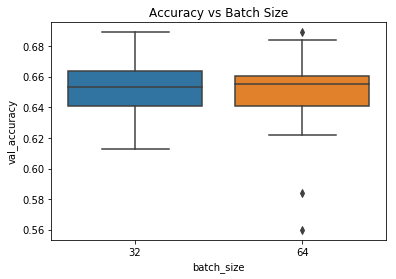

In [14]:
import seaborn as sns

import glob
import os

# read from the csv file that stores all the experiment result 
# Talos will automatically save it when Scan is called

onlyfiles = glob.glob(os.getcwd() + '/aspect_prediction_1/*')
latest_file = max(onlyfiles, key=os.path.getctime)
df = pd.read_csv(latest_file)

# draw a boxplot of accuracy vs batch size
metric = 'batch_size'
ax = sns.boxplot(x=metric, y="val_accuracy", data=df.reset_index())
ax.set_title('Accuracy vs Batch Size')

Text(0.5,1,'Accuracy vs Dropout Rate')

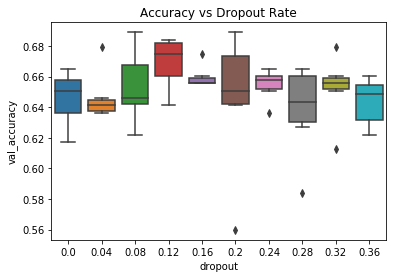

In [15]:
# draw a boxplot of accuracy vs dropout rate

metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_accuracy", data=df.reset_index())
ax.set_title('Accuracy vs Dropout Rate')

Text(0.5,1,'Accuracy vs LSTM hidden units')

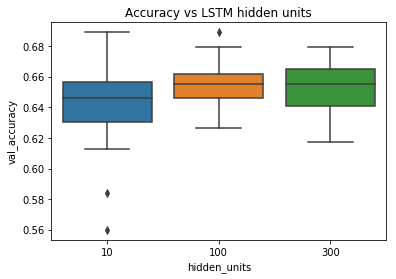

In [16]:
# draw a boxplot of accuracy vs number of hidden units

metric = 'hidden_units'
ax = sns.boxplot(x=metric, y="val_accuracy", data=df.reset_index())
ax.set_title('Accuracy vs LSTM hidden units')

Text(0.5,1,'Accuracy vs dropout/ LSTM hidden units')

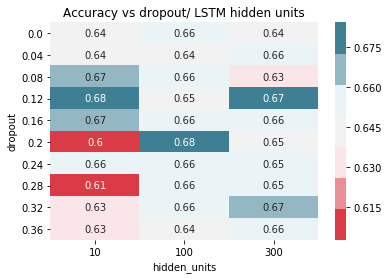

In [17]:
# draw a heatmap of accuracy vs dropout / number of hidden units

df_grid = df.reset_index().groupby(["dropout", "hidden_units"]).val_accuracy.mean().unstack()
ax = sns.heatmap(data=df_grid, cmap= (sns.diverging_palette(10, 220, sep=80, n=7)), annot=True)
ax.set_title('Accuracy vs dropout/ LSTM hidden units')

In [18]:
# manually choose the model with best hyperparameter
import time

start = time.time()

lstm_out = 10

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.36))
model.add(LSTM(lstm_out, dropout= 0.36, recurrent_dropout=0.36))
model.add(BatchNormalization())
model.add(Dense(8,activation='softmax'))
model.add(Dense(4,activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

history = model.fit(x_train, y_train,  # 80% as training data
      validation_split=0.1,
      batch_size=64,
      epochs=50, class_weight = class_weights)

print("Time taken for model training: " + str(time.time()-start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2683 samples, validate on 299 samples
Epoch 1/50
2683/2683 [==============================] - 1s 375us/step - loss: 1.3674 - accuracy: 0.3392 - val_loss: 1.3270 - val_accuracy: 0.4849
Epoch 2/50
2683/2683 [==============================] - 0s 98us/step - loss: 1.3157 - accuracy: 0.4428 - val_loss: 1.2888 - val_accuracy: 0.4916
Epoch 3/50
2683/2683 [==============================] - 0s 97us/step - loss: 1.2715 - accuracy: 0.4711 - val_loss: 1.2462 - val_accuracy: 0.5050
Epoch 4/50
2683/2683 [==============================] - 0s 98us/step - loss: 1.2413 - accuracy: 0.4853 - val_loss: 1.2073 - val_accuracy: 0.5318
Epoch 5/50
2683/2683 [==============================] - 0s 98us/step - loss: 1.2184 - accuracy: 0.4987 - val_loss: 1.1750 - val_accuracy: 0.5485
Epoch 6/50
2683/2683 [==============================] - 0s 98us/step - loss: 1.1961 - accuracy: 0.5002 - va

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


<IPython.core.display.Javascript object>


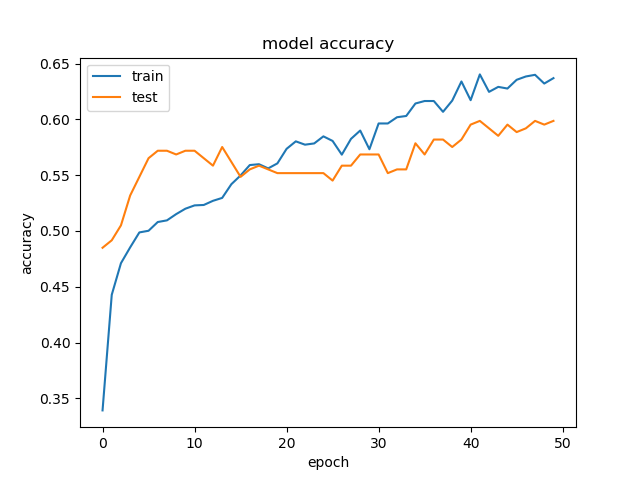

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

print(history.history.keys())

# plot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


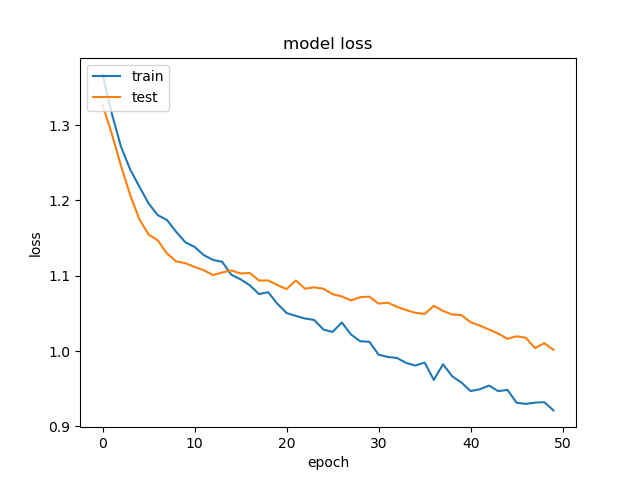

In [20]:
%matplotlib notebook

# plot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
import joblib

# save the model into a sav file

filename = 'finalized_lstm_aspect.sav'
joblib.dump(model, filename)

loaded_model_aspect = joblib.load(filename)

In [22]:
print('\n# Evaluate using test data')
results = loaded_model_aspect.evaluate(x_test, y_test, batch_size=64)
print('test loss, test acc:', results)

output = loaded_model_aspect.predict(x_test)


# Evaluate using test data
745/745 [==============================] - 0s 215us/step
test loss, test acc: [0.8309584062371478, 0.6979866027832031]


In [23]:
predicted_output = []

# look at the probability of each class and convert them back into the predicted class category
for ot in output:
    a = ot.tolist()
    predicted_output.append(a.index(max(a)))
predicted_output = label_encoder.inverse_transform(predicted_output)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
# put it into a dataframe, group those that belongs to same sentence (same review id) into one row

df = pd.DataFrame({'review_id': id_test,
     'predicted_category': predicted_output})
predicted_category = df.groupby('review_id')['predicted_category'].apply(lambda x: ','.join(x))
predicted_category  # this is in series format

review_id
2114    FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY,FOOD#QU...
2115               FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY
2127                                         FOOD#QUALITY
2130                                         FOOD#QUALITY
2135    FOOD#QUALITY,FOOD#QUALITY,FOOD#QUALITY,FOOD#QU...
2136                                         FOOD#QUALITY
2138                                         FOOD#QUALITY
2140                                         FOOD#QUALITY
2141                                         FOOD#QUALITY
2142                                         FOOD#QUALITY
2144                                         FOOD#QUALITY
2146                                         FOOD#QUALITY
2148                                         FOOD#QUALITY
2149                                         FOOD#QUALITY
2151                                         FOOD#QUALITY
2152                                      SERVICE#GENERAL
2154                RESTAURANT#GENERAL,RESTAURANT#GENERAL
2155

In [25]:
# save both actual category and predicted category into two different csv files
# will be used to the calculation of sentiment prediction accuracy in another notebook file

actual_category.to_csv("actual_category.csv")
predicted_category.to_csv("predicted_category.csv")

In [26]:
# to see how many sentence got all the categories right

no_of_sentence = predicted_category.size
no_of_sentence_correct = 0

# for each sentence
for index, value in predicted_category.items():
    match = True
    
    # all the predicted categories for each sentence
    predicted_value = value.split(',')
    
    # all the actual ground truth categories for each sentence
    actual_value = actual_category[actual_category['review_id'] == index]['category']
    actual_value = actual_value.tolist()[0].split(',')
    
    # for each actual category
    for elem in actual_value:
        
        # if not being predicted
        if elem not in predicted_value:
            match = False
            break
            
    if match:
        # if all actual categories are correctly predicted
        no_of_sentence_correct += 1

# print the accuracy value
print(no_of_sentence_correct/no_of_sentence)

0.7599009900990099
